In [ ]:
import pandas as pd
import numpy as np
import time
import datetime
import os

from utils import raw_data_path,dump_pickle,load_pickle,cal_log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import lightgbm as lgb
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.figsize'] = [12, 8]
params = {
    'max_depth': 3,                 
    'num_leaves': 71,
   'min_data_in_leaf': 138,
    'learning_rate': 0.04,          
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'verbose': 2,
    'metric': 'binary_logloss',
    'bagging_fraction': 0.8991,
    'feature_fraction': 0.9941,
    
}

if __name__ == '__main__':
    
    
    t0 = time.time()
    train_data = load_pickle(path='../data/train_final_onehot.pkl')    
    train_Y = train_data['is_trade']
    train_data.drop('is_trade', axis=1, inplace=True) 

    
    cv_data = load_pickle(path='../data/valid_final_onehot.pkl')
    cv_Y = cv_data['is_trade']
    cv_data.drop('is_trade', axis=1, inplace=True) 

    
    test_data = load_pickle(path='../data/test_final_onehot.pkl')
    test_Y = test_data['is_trade']
    test_data.drop('is_trade', axis=1, inplace=True) 

    print('train shap:',train_data.shape)
    print('cv shape', cv_data.shape)
    print('test shape', test_data.shape)
    
    
    test_file = 'round1_ijcai_18_test_b_20180418.txt'
    test = pd.read_table(raw_data_path + test_file,delim_whitespace=True)
    test_id = test.instance_id
    
    drop_cols = ['context_id', 'user_id', 'shop_id', 'item_id','item_brand_id', 'instance_id']

    train_data.drop(drop_cols,axis=1,inplace=True)
    cv_data.drop(drop_cols,axis=1,inplace=True)
    test_data.drop(drop_cols,axis=1,inplace=True)
    
#     train_data = pd.concat([train_data, cv_data], axis=0)
#     train_Y =  pd.concat([train_Y, cv_Y], axis=0)

    
#     lgb_train = lgb.Dataset(train_data.values, train_Y)
#     lgb_test = lgb.Dataset(test_data.values, test_Y)
#     gbm = lgb.train(params=params,            #参数
#                     train_set=lgb_train,      #要训练的数据
#                     num_boost_round=5000,     #迭代次数
#                     valid_sets=[lgb_train, lgb_test],        #训练时需要评估的列表
#                     verbose_eval=20,       #
#                     early_stopping_rounds=150)
    
#     predict_test = gbm.predict(test_data.values)
#     print('预测正样本比例:', x`(predict_test>=0.5).sum()/len(predict_test))
    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    lgb_cv = lgb.Dataset(cv_data.values, cv_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=5000,     #迭代次数
                    valid_sets=[lgb_train, lgb_cv],        #训练时需要评估的列表
                    verbose_eval=20,       #
                    early_stopping_rounds=150)
    best_round = gbm.current_iteration()
    predict_train = gbm.predict(train_data.values)
    predict_cv = gbm.predict(cv_data.values)
    predict_test = gbm.predict(test_data.values)
    
#     feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)

    
    print('训练损失:',cal_log_loss(predict_train, train_Y))
    print('验证损失:',cal_log_loss(predict_cv, cv_Y))
    t1 = time.time()
    print('训练时间:',t1 - t0)
    
    #全量评测
    train_data = pd.concat([train_data, cv_data],axis=0)
    train_Y = np.append(train_Y, cv_Y)
    
    lgb_train = lgb.Dataset(train_data.values, train_Y)
    gbm = lgb.train(params=params,            #参数
                    train_set=lgb_train,      #要训练的数据
                    num_boost_round=best_round,     #迭代次数
                    verbose_eval=True)
    predict_test = gbm.predict(test_data.values)
    print('测试损失:',cal_log_loss(gbm.predict(train_data.values), train_Y))
    submission = pd.DataFrame({'instance_id':test_id,'predicted_score':predict_test})
    print('预测正样本比例:',len(submission.loc[submission.predicted_score>=0.5])/len(submission))
    submission.to_csv(r'../result/lgb_{}.txt'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False, sep=' ',line_terminator='\r')

train shap: (420676, 338)
cv shape (57411, 338)
test shape (42888, 338)
Training until validation scores don't improve for 150 rounds.
[20]	training's binary_logloss: 0.287701	valid_1's binary_logloss: 0.285365
[40]	training's binary_logloss: 0.159876	valid_1's binary_logloss: 0.15585
[60]	training's binary_logloss: 0.113859	valid_1's binary_logloss: 0.108787
[80]	training's binary_logloss: 0.0975744	valid_1's binary_logloss: 0.091703
[100]	training's binary_logloss: 0.0920024	valid_1's binary_logloss: 0.0852731
[120]	training's binary_logloss: 0.0899382	valid_1's binary_logloss: 0.0827493
[140]	training's binary_logloss: 0.0889839	valid_1's binary_logloss: 0.0817119
[160]	training's binary_logloss: 0.0883735	valid_1's binary_logloss: 0.0811583
[180]	training's binary_logloss: 0.0878997	valid_1's binary_logloss: 0.0808629
[200]	training's binary_logloss: 0.0875255	valid_1's binary_logloss: 0.0806376
[220]	training's binary_logloss: 0.0872057	valid_1's binary_logloss: 0.0803587
[240]	tr

In [5]:
print('预测正样本比例:',(predict_test>=0.5).sum()/len(predict_test))

预测正样本比例: 0.0


In [6]:
predict_test

array([0.01978761, 0.00562079, 0.02215408, ..., 0.00747656, 0.02944235,
       0.00638451])

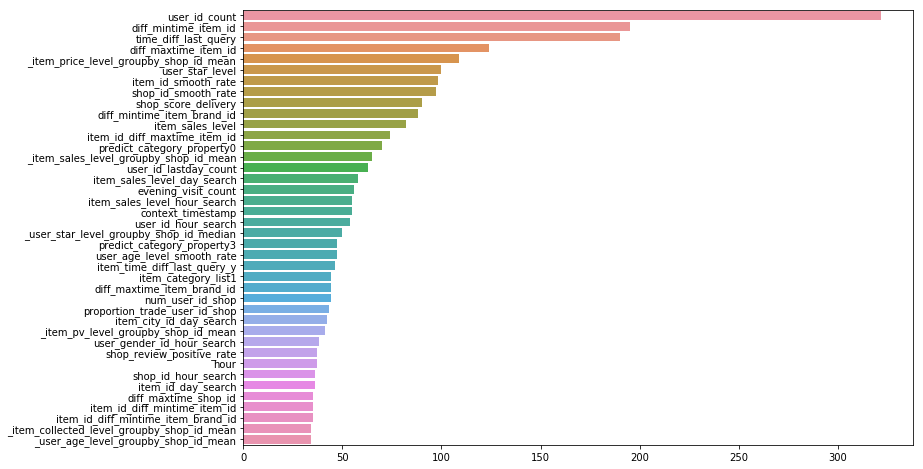

In [7]:
feat_imp = pd.Series(gbm.feature_importance(), index=train_data.columns).sort_values(ascending=False)[:40]
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.show()

In [8]:
(train_data == -1).sum(axis=0).sort_values(ascending=False)

user_id_lastday_count                 444116
time_diff_last_query                  197685
item_id_lastday_count                 147071
shop_id_lastday_count_y               140341
shop_id_lastday_count_x               140341
item_brand_id_lastday_count           137734
item_city_id_lastday_count            135707
item_price_level_lastday_count        135681
item_pv_level_lastday_count           135679
item_sales_level_lastday_count        135672
item_collected_level_lastday_count    135672
item_id_smooth_rate                    85104
proportion_trade_user_id_shop          80567
num_user_id_shop                       80567
num_trade_None_shop                    80567
num_None_shop                          80567
proportion_trade_None_shop             80567
num_trade_user_id_shop                 80567
shop_id_smooth_rate                    80567
item_brand_id_smooth_rate              79402
item_city_id_smooth_rate               78284
item_price_level_smooth_rate           78268
shop_star_